In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [5]:
!mv nfl.db nfl-bak.db
!cp ../Scraping/nfl.db .

In [6]:
# Connect to SQLite Database
conn = sqlite3.connect('nfl.db')
cursor = conn.cursor()

# Load data from SQLite database tables into pandas DataFrames
teams_df = pd.read_sql_query("SELECT * FROM Teams", conn)
games_df = pd.read_sql_query("SELECT * FROM Games", conn)
playerstats_df = pd.read_sql_query("SELECT * FROM PlayerStats", conn)

# Close the connection
conn.close()

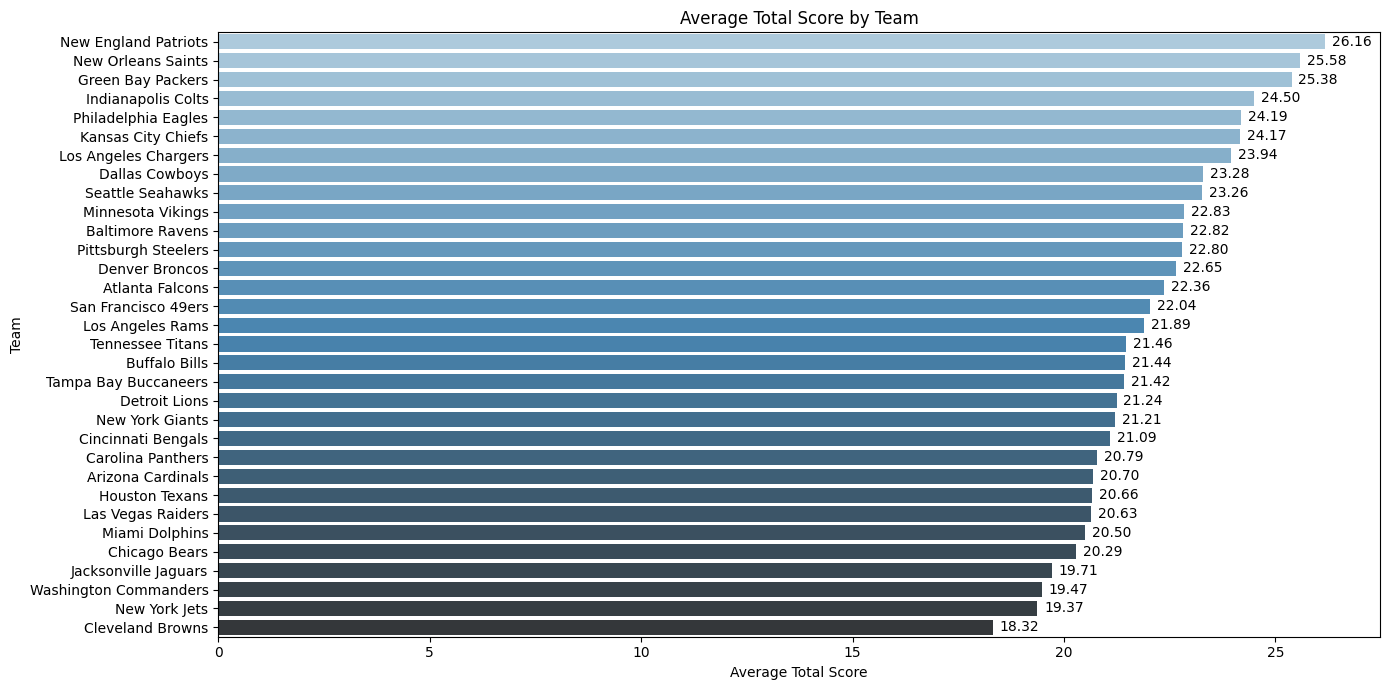

In [14]:
# Top Scoring Teams

conn = sqlite3.connect('nfl.db')

games_df = pd.read_sql_query("SELECT * FROM games", conn)
teams_df = pd.read_sql_query("SELECT * FROM teams", conn)

conn.close()

# Calc and average home+away scores for every team
home_scores = games_df.groupby('home_team')['home_score'].mean().reset_index()
home_scores.columns = ['team', 'avg_home_score']
away_scores = games_df.groupby('away_team')['away_score'].mean().reset_index()
away_scores.columns = ['team', 'avg_away_score']
avg_scores = pd.merge(home_scores, away_scores, on='team')
avg_scores['avg_total_score'] = avg_scores[['avg_home_score', 'avg_away_score']].mean(axis=1)

# Merge with teams_df to get the team names
avg_scores = pd.merge(avg_scores, teams_df, left_on='team', right_on='TeamID')

# Select relevant columns and sort by the overall average score
avg_scores = avg_scores[['Team', 'avg_home_score', 'avg_away_score', 'avg_total_score']]
avg_scores = avg_scores.sort_values(by='avg_total_score', ascending=False)

# Plot the results
plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='avg_total_score', y='Team', data=avg_scores, hue='Team', palette='Blues_d', dodge=False, legend=False)

# Add titles and labels
plt.title('Average Total Score by Team')
plt.xlabel('Average Total Score')
plt.ylabel('Team')

# Add the numeric values next to each bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.2f', label_type='edge', padding=5)

plt.tight_layout()

plt.show()

# Print the results in table
# print(avg_scores)

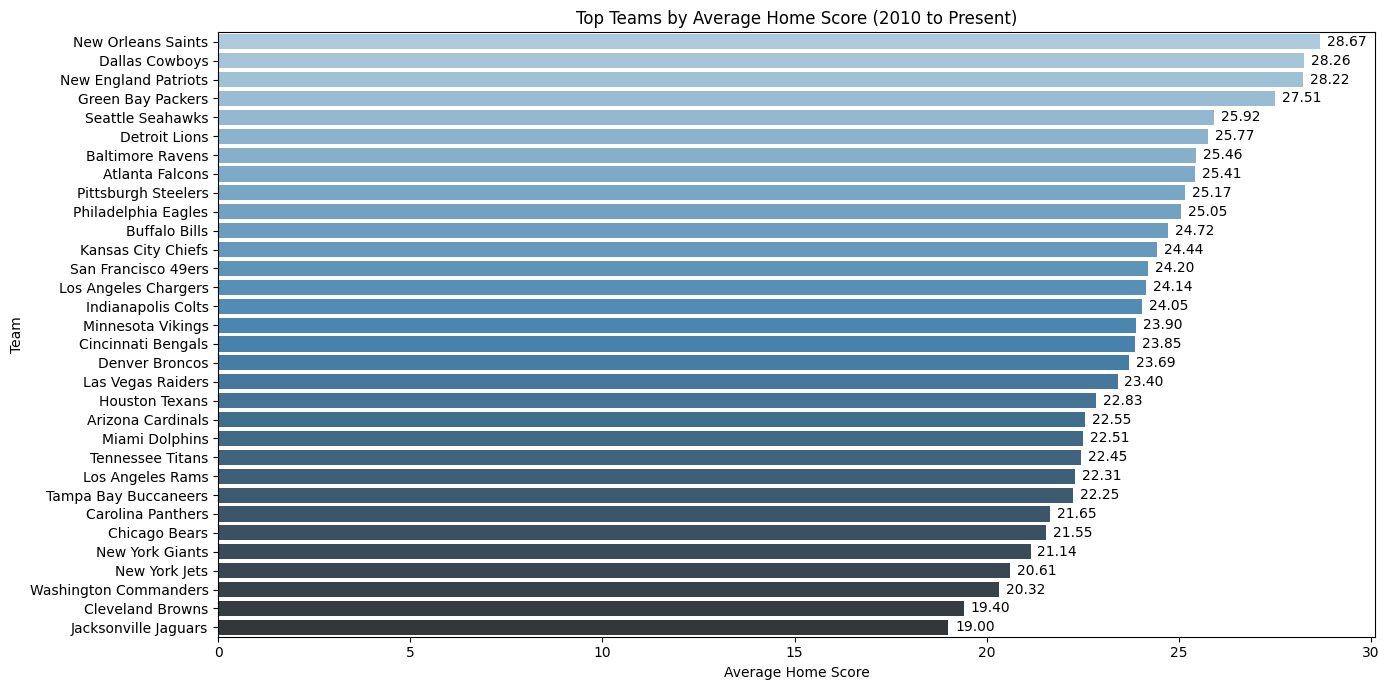

In [19]:
# Top Teams by Average Home Score (since 2010)

games_df_filtered = games_df[games_df['season'] >= 2010]

# Calculate and sort the top home teams by average score
top_home_teams = games_df_filtered.groupby('home_team')['home_score'].mean().reset_index().merge(teams_df, left_on='home_team', right_on='TeamID').sort_values(by='home_score', ascending=False)

plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='home_score', y='Team', data=top_home_teams, palette='Blues_d', hue='Team', dodge=False, legend=False)
plt.title('Top Teams by Average Home Score (2010 to Present)')
plt.xlabel('Average Home Score')
plt.ylabel('Team')

# Add the numeric values next to each bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.2f', label_type='edge', padding=5)

plt.tight_layout()

plt.show()


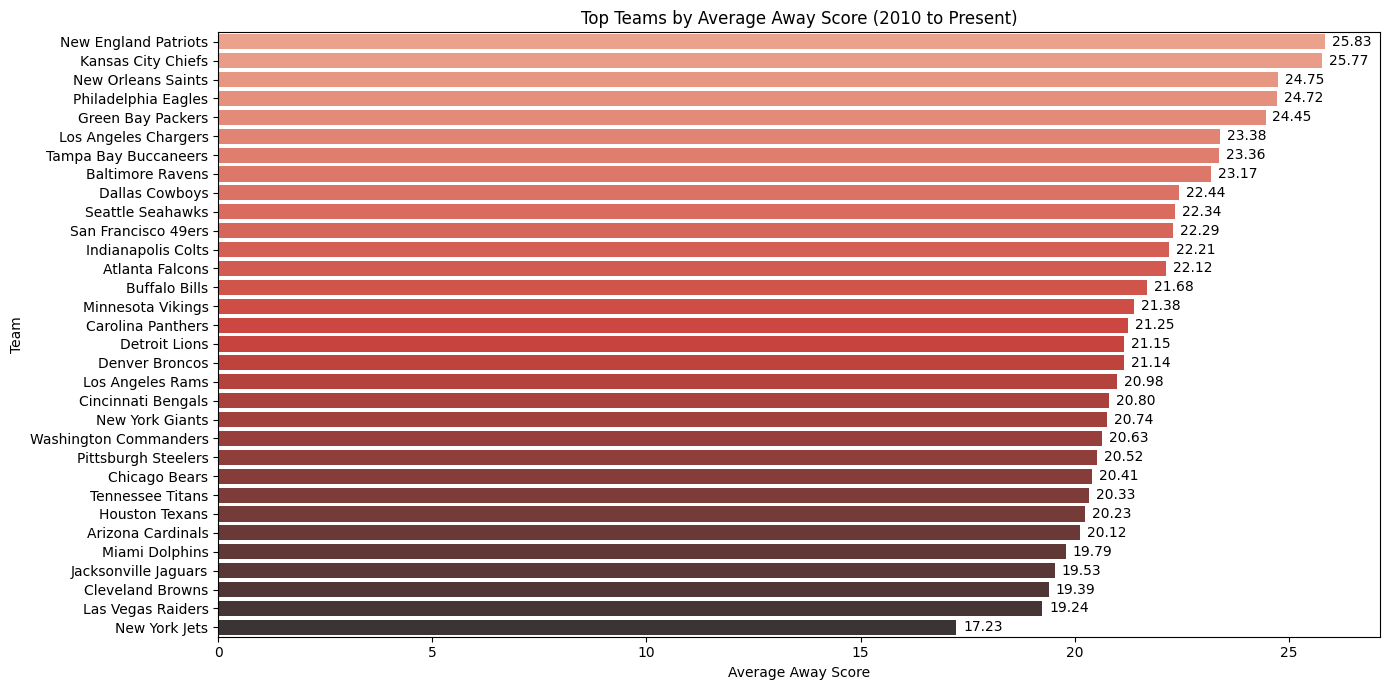

In [20]:
# Top Teams by Average Away Score (since 2010)

games_df_filtered = games_df[games_df['season'] >= 2010]

# Calculate and sort the top away teams by average score
top_away_teams = games_df_filtered.groupby('away_team')['away_score'].mean().reset_index().merge(teams_df, left_on='away_team', right_on='TeamID').sort_values(by='away_score', ascending=False)

plt.figure(figsize=(14, 7))
bar_plot = sns.barplot(x='away_score', y='Team', data=top_away_teams, palette='Reds_d', hue='Team', dodge=False, legend=False)
plt.title('Top Teams by Average Away Score (2010 to Present)')
plt.xlabel('Average Away Score')
plt.ylabel('Team')

# Add the numeric values next to each bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.2f', label_type='edge', padding=5)
    
plt.tight_layout()

# Save visualization
plt.show()

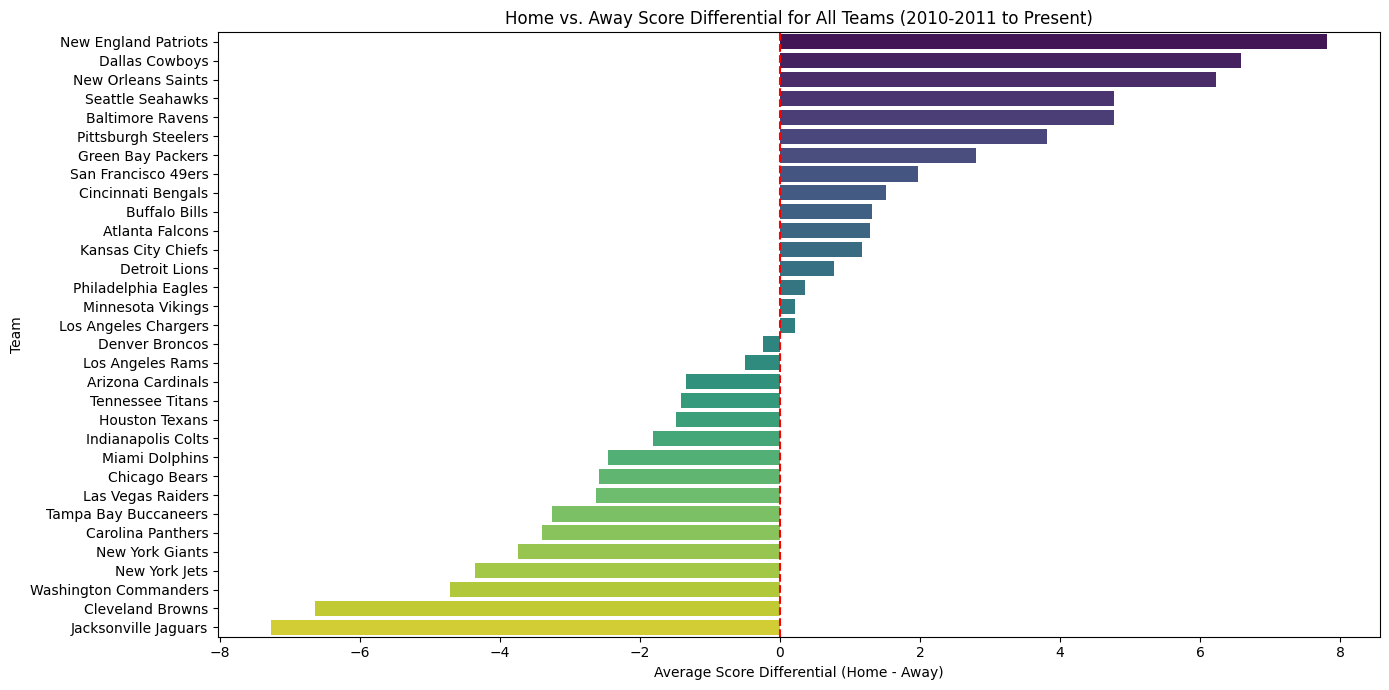

In [21]:
# Home vs. Away Score Differential for All Teams (since 2010)

games_df_filtered = games_df[games_df['season'] >= 2010]

home_away_diff = games_df_filtered.groupby('home_team').agg({'home_score': 'mean', 'away_score': 'mean'}).reset_index()
home_away_diff = home_away_diff.merge(games_df_filtered.groupby('away_team')['home_score'].mean().reset_index(), left_on='home_team', right_on='away_team')
home_away_diff['score_diff'] = home_away_diff['home_score_x'] - home_away_diff['home_score_y']
home_away_diff = home_away_diff.merge(teams_df, left_on='home_team', right_on='TeamID').sort_values(by='score_diff', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x='score_diff', y='Team', data=home_away_diff, palette='viridis', hue='Team', dodge=False, legend=False)
plt.title('Home vs. Away Score Differential for All Teams (2010-2011 to Present)')
plt.xlabel('Average Score Differential (Home - Away)')
plt.ylabel('Team')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()

plt.show()

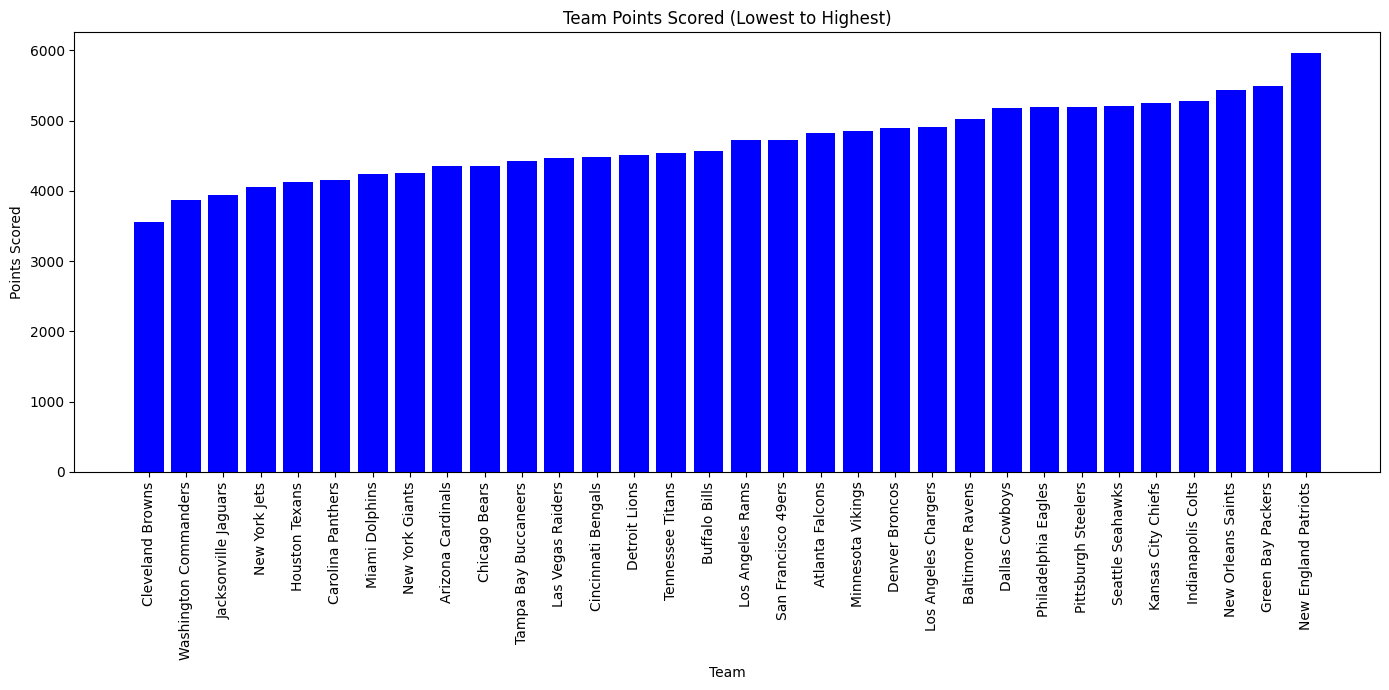

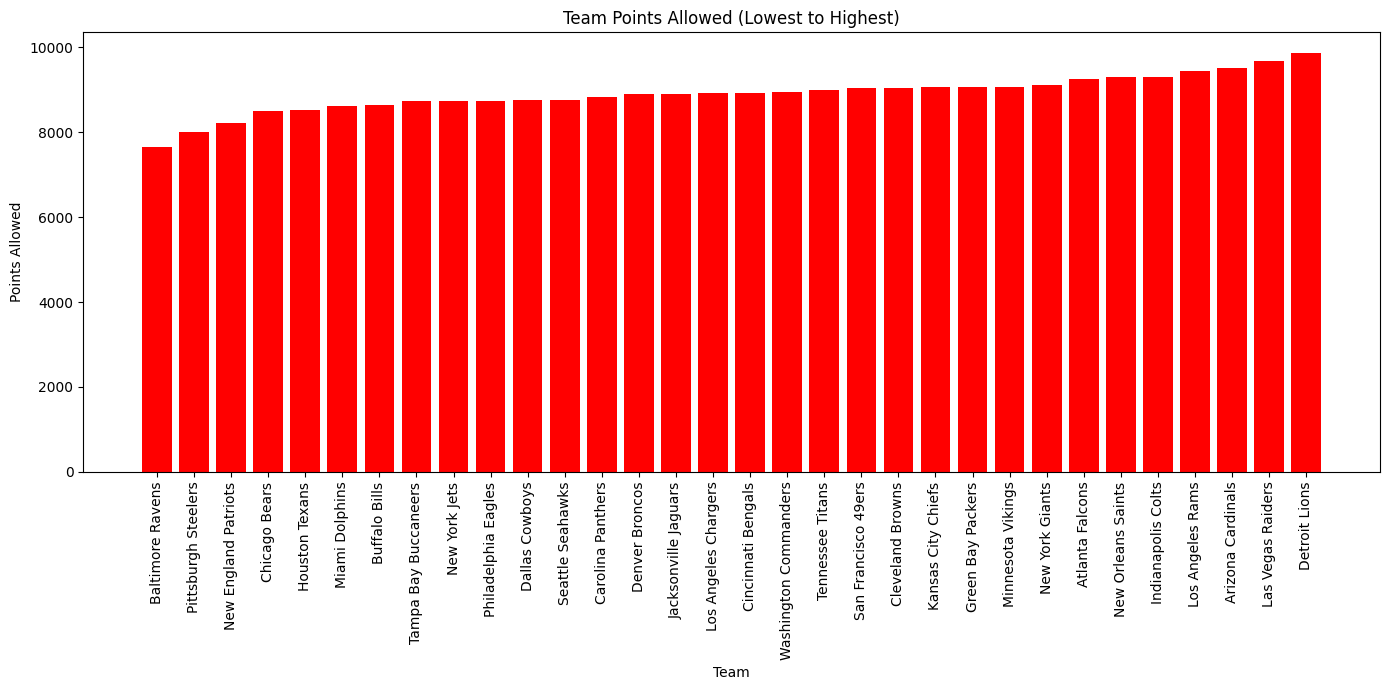

In [22]:
# Team Points Allowed vs. Points Scored

team_points = games_df.groupby('home_team').agg({
    'home_score': 'sum', 'away_score': 'sum'
}).reset_index()

team_points = team_points.merge(teams_df[['TeamID', 'Team']], left_on='home_team', right_on='TeamID', how='left')
team_points['points_scored'] = team_points['home_score']
team_points['points_allowed'] = games_df.groupby('away_team')['home_score'].sum().values + team_points['away_score']
team_points = team_points[['Team', 'points_scored', 'points_allowed']]

# Sort by points scored (ascending)
team_points_scored_sorted = team_points.sort_values(by='points_scored', ascending=True)

# Sort by points allowed (ascending)
team_points_allowed_sorted = team_points.sort_values(by='points_allowed', ascending=True)

# Plot points scored bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_points_scored_sorted['Team'], team_points_scored_sorted['points_scored'], color='blue')
plt.title('Team Points Scored (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Points Scored')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot points allowed bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_points_allowed_sorted['Team'], team_points_allowed_sorted['points_allowed'], color='red')
plt.title('Team Points Allowed (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Points Allowed')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


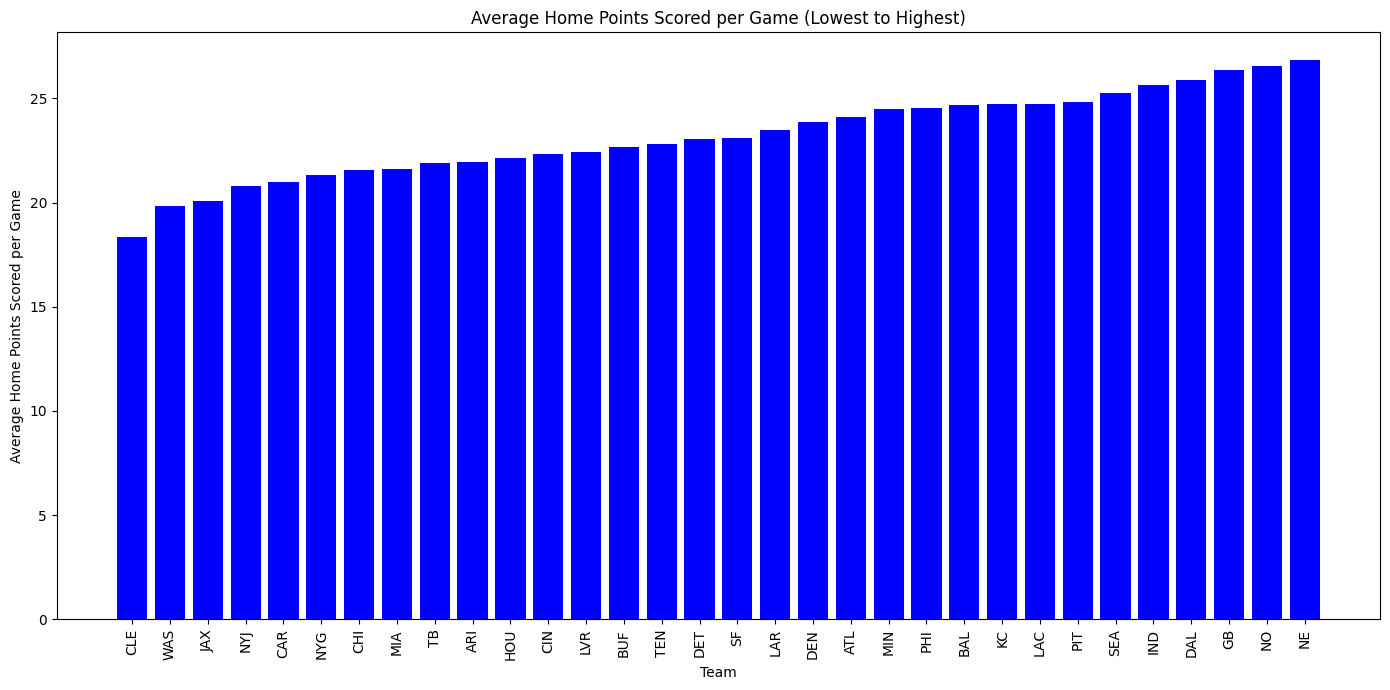

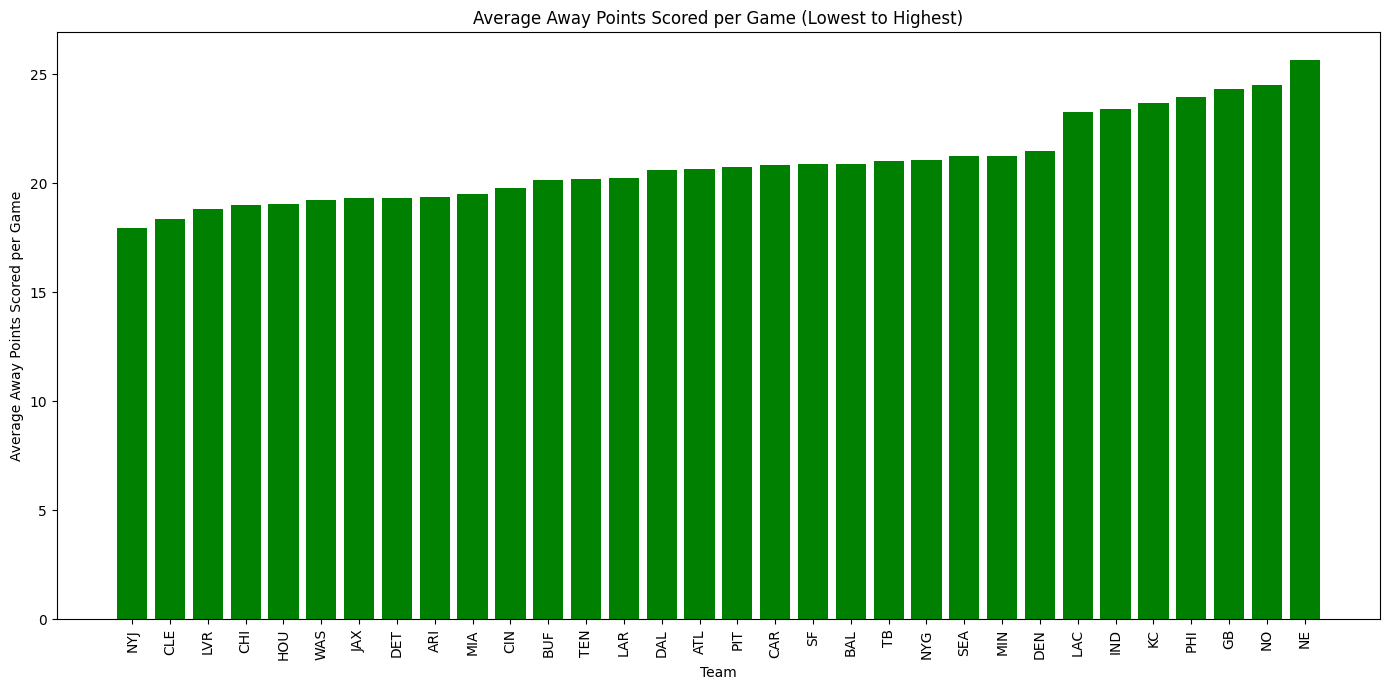

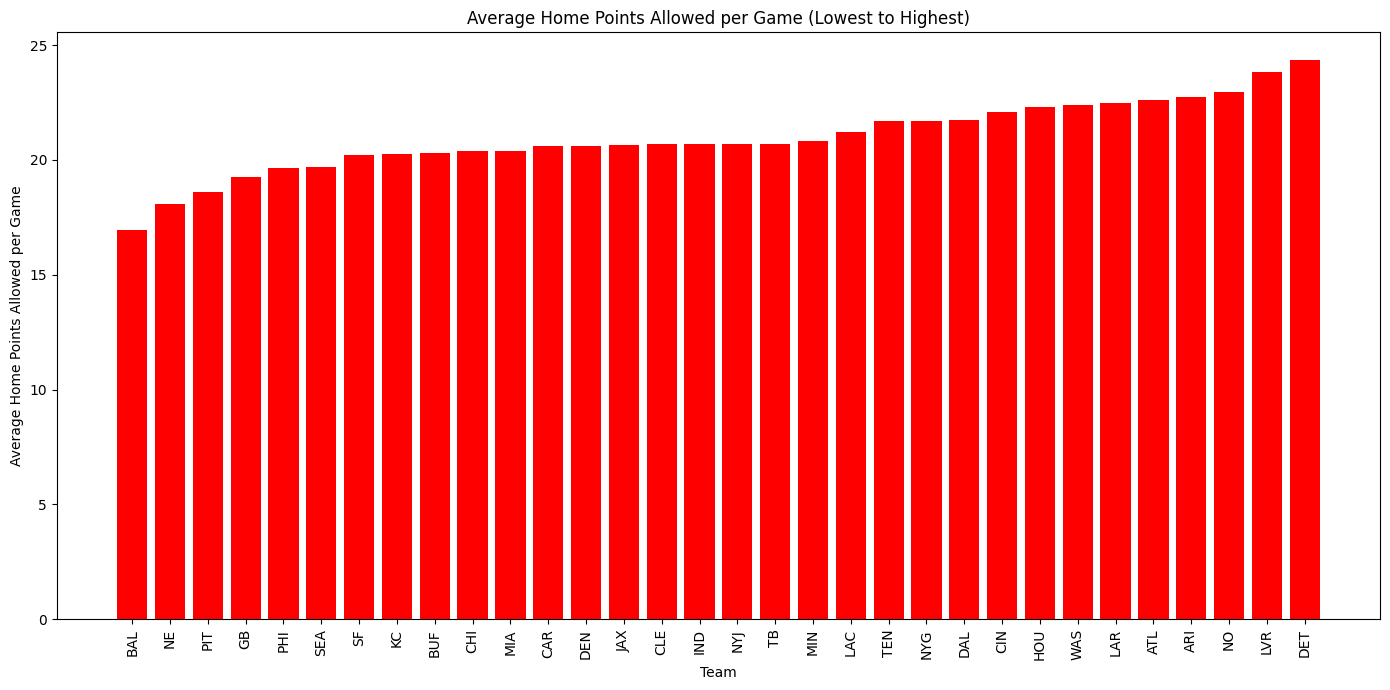

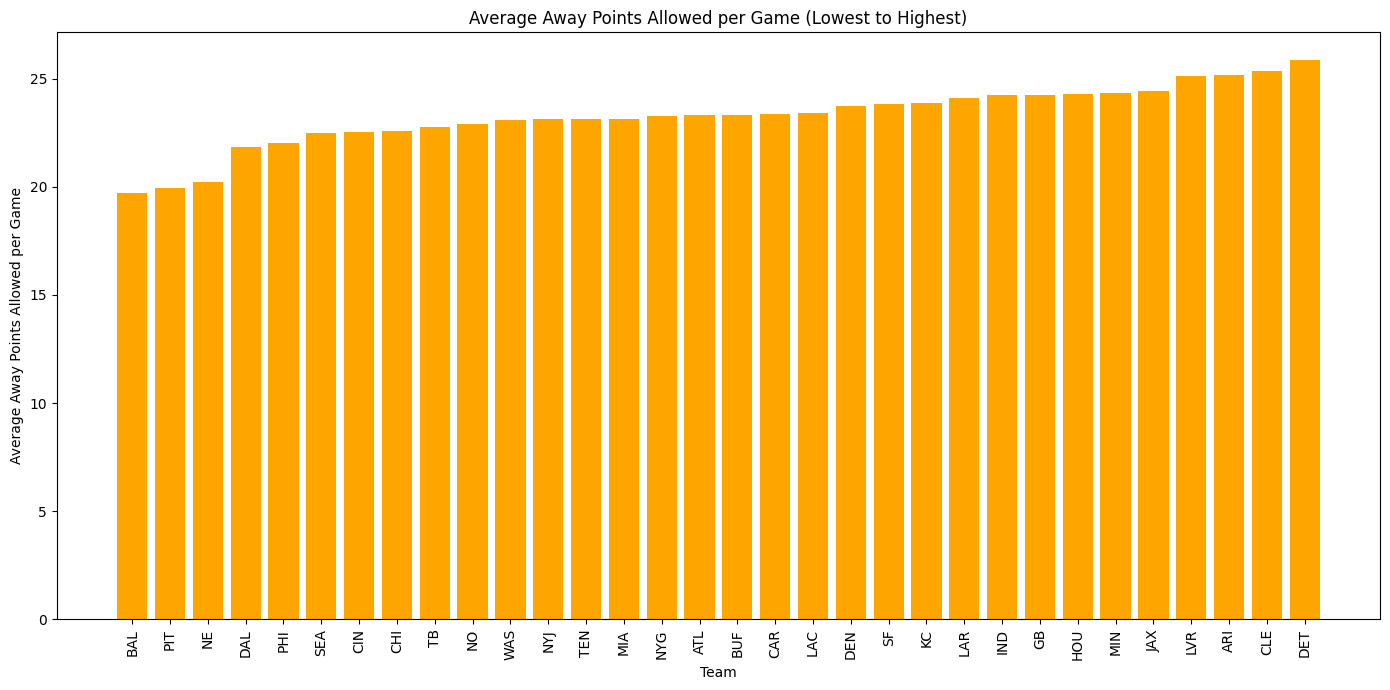

In [3]:
# Calculate average points scored for home and away games_df
home_avg_points_scored = games_df.groupby('home_team')['home_score'].mean().reset_index()
home_avg_points_scored.columns = ['Team', 'avg_home_points_scored']

away_avg_points_scored = games_df.groupby('away_team')['away_score'].mean().reset_index()
away_avg_points_scored.columns = ['Team', 'avg_away_points_scored']

# Calculate average points allowed for home and away games_df
home_avg_points_allowed = games_df.groupby('home_team')['away_score'].mean().reset_index()
home_avg_points_allowed.columns = ['Team', 'avg_home_points_allowed']

away_avg_points_allowed = games_df.groupby('away_team')['home_score'].mean().reset_index()
away_avg_points_allowed.columns = ['Team', 'avg_away_points_allowed']

# Merge all averages into a single DataFrame
avg_points = pd.merge(home_avg_points_scored, away_avg_points_scored, on='Team')
avg_points = pd.merge(avg_points, home_avg_points_allowed, on='Team')
avg_points = pd.merge(avg_points, away_avg_points_allowed, on='Team')

avg_points

# Sort by average home points scored (ascending)
team_home_points_scored_sorted = avg_points.sort_values(by='avg_home_points_scored', ascending=True)

# Sort by average away points scored (ascending)
team_away_points_scored_sorted = avg_points.sort_values(by='avg_away_points_scored', ascending=True)

# Sort by average home points allowed (ascending)
team_home_points_allowed_sorted = avg_points.sort_values(by='avg_home_points_allowed', ascending=True)

# Sort by average away points allowed (ascending)
team_away_points_allowed_sorted = avg_points.sort_values(by='avg_away_points_allowed', ascending=True)

# Plot average home points scored bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_home_points_scored_sorted['Team'], team_home_points_scored_sorted['avg_home_points_scored'], color='blue')
plt.title('Average Home Points Scored per Game (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Average Home Points Scored per Game')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot average away points scored bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_away_points_scored_sorted['Team'], team_away_points_scored_sorted['avg_away_points_scored'], color='green')
plt.title('Average Away Points Scored per Game (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Average Away Points Scored per Game')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot average home points allowed bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_home_points_allowed_sorted['Team'], team_home_points_allowed_sorted['avg_home_points_allowed'], color='red')
plt.title('Average Home Points Allowed per Game (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Average Home Points Allowed per Game')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot average away points allowed bar chart (sorted)
plt.figure(figsize=(14, 7))
plt.bar(team_away_points_allowed_sorted['Team'], team_away_points_allowed_sorted['avg_away_points_allowed'], color='orange')
plt.title('Average Away Points Allowed per Game (Lowest to Highest)')
plt.xlabel('Team')
plt.ylabel('Average Away Points Allowed per Game')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
